In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz, lfilter
from scipy.io import wavfile
from IPython.display import Audio
from scipy import signal
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from IPython.display import Audio, display


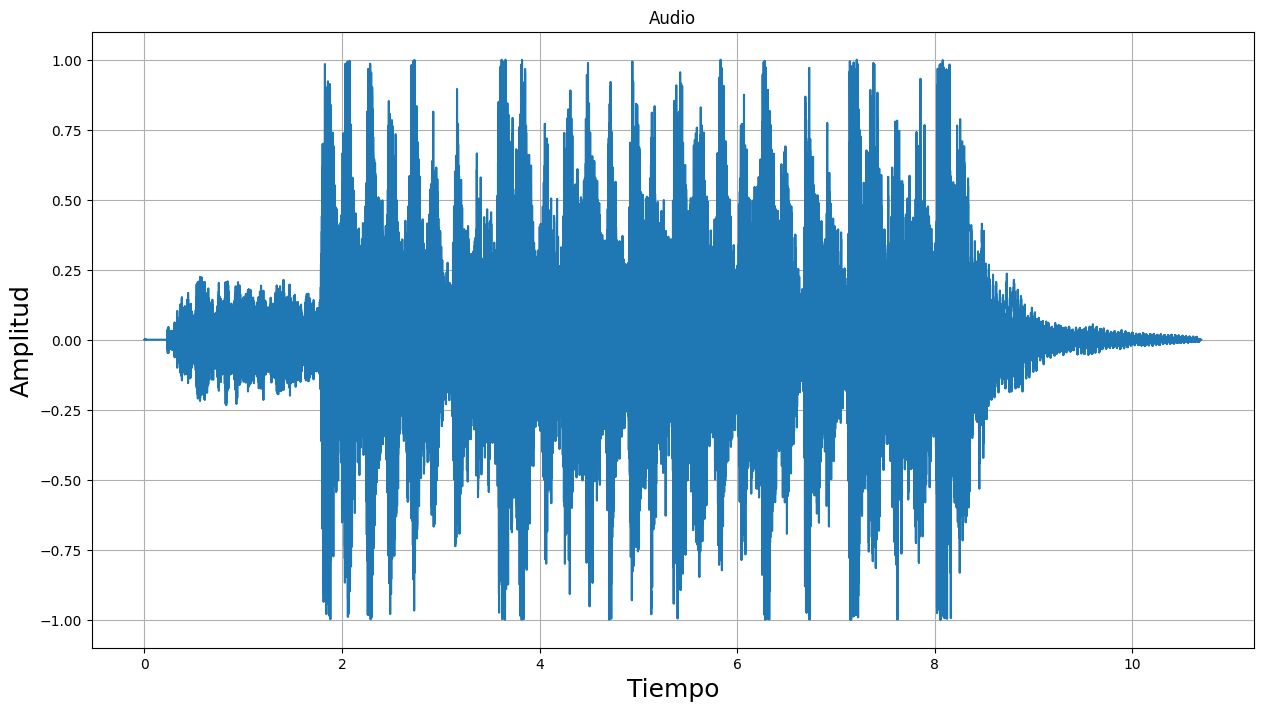

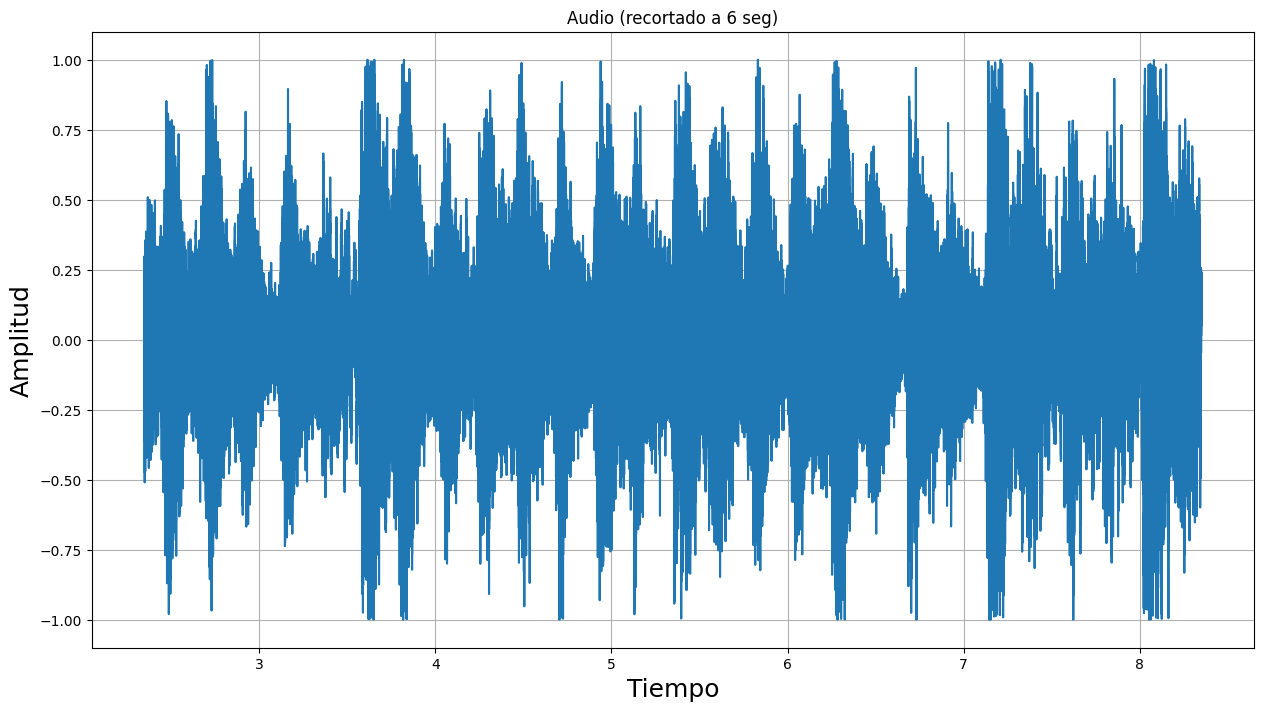

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from IPython.display import Audio, display

# Cargar el archivo de audio
fs, x = read('audio.wav')  # Carga del audio descargado.

# Verificar y manejar si los datos son estéreo (2 canales)
if len(x.shape) > 1:
    x = x[:, 0]  # Usar solo el primer canal si el audio es estéreo
    
# Normalizar la señal
x = x / float(np.max(np.abs(x)))

# Eliminar nivel DC
nivel_DC = np.mean(x)
x -= nivel_DC

# Crear el vector de tiempo
t = np.arange(0, float(len(x)) / fs, 1.0 / fs)

# Gráfica de la señal
plt.figure(figsize=(15, 8))
plt.plot(t, x)
plt.grid()
plt.title('Audio')
plt.ylabel('Amplitud', fontsize=18)
plt.xlabel('Tiempo', fontsize=18)
plt.show()

# Reproducir el audio
display(Audio(x, rate=fs))

# Recortar un segmento del audio
duracion_total = len(x) / fs  # Duración total del audio en segundos
duracion_segmento = 6  # Duración del segmento a recortar (6 segundos)
muestras_segmento = int(duracion_segmento * fs)  # Número de muestras para representar el segmento de 6 segundos

# Inicio del segmento
inicio = int((duracion_total - duracion_segmento) / 2 * fs)

# Final del segmento
fin = inicio + muestras_segmento

# Segmento de audio recortado
audio_recortado = x[inicio:fin]

# Gráfica de la señal recortada
plt.figure(figsize=(15, 8))
plt.plot(t[inicio:fin], audio_recortado)
plt.grid()
plt.title('Audio (recortado a 6 seg)')
plt.ylabel('Amplitud', fontsize=18)
plt.xlabel('Tiempo', fontsize=18)
plt.show()

# Reproducir el audio recortado
display(Audio(audio_recortado, rate=fs))


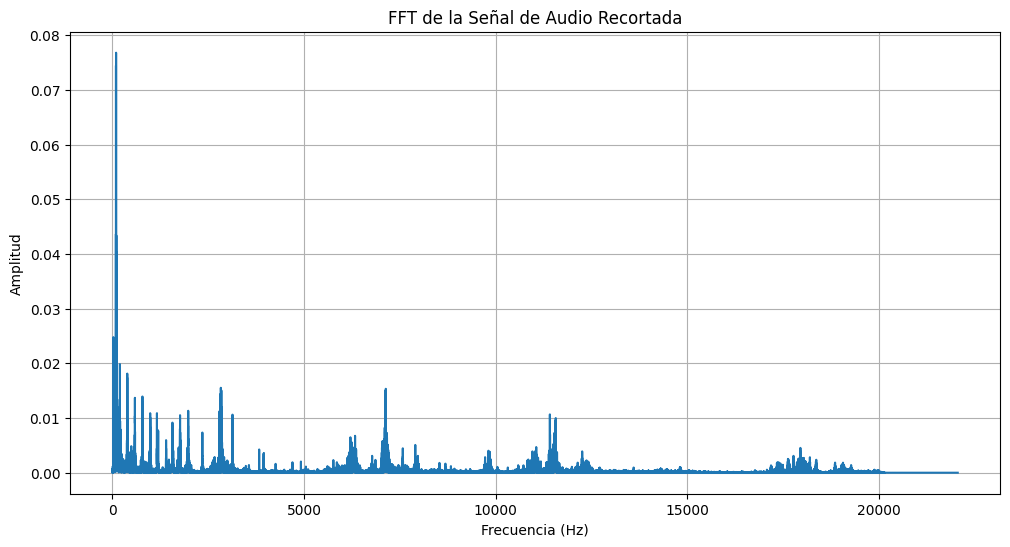

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# FFT del segmento recortado
N = len(audio_recortado)
T = 1.0 / fs
yf = np.fft.fft(audio_recortado)
xf = np.linspace(0.0, fs / 2.0, N // 2)

# Plot de la FFT
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0 / N * np.abs(yf[:N // 2]))
plt.grid()
plt.title('FFT de la Señal de Audio Recortada')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Amplitud')
plt.show()

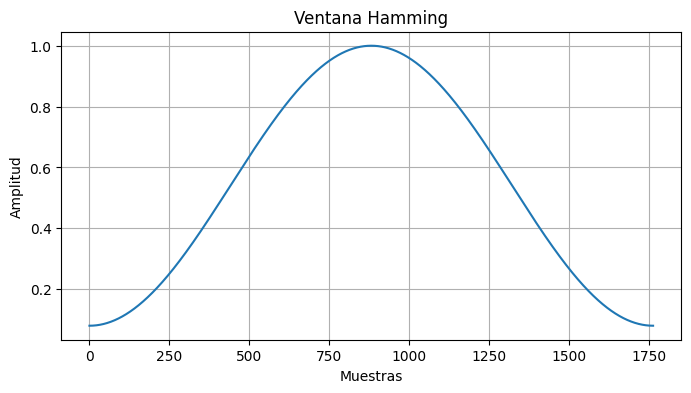

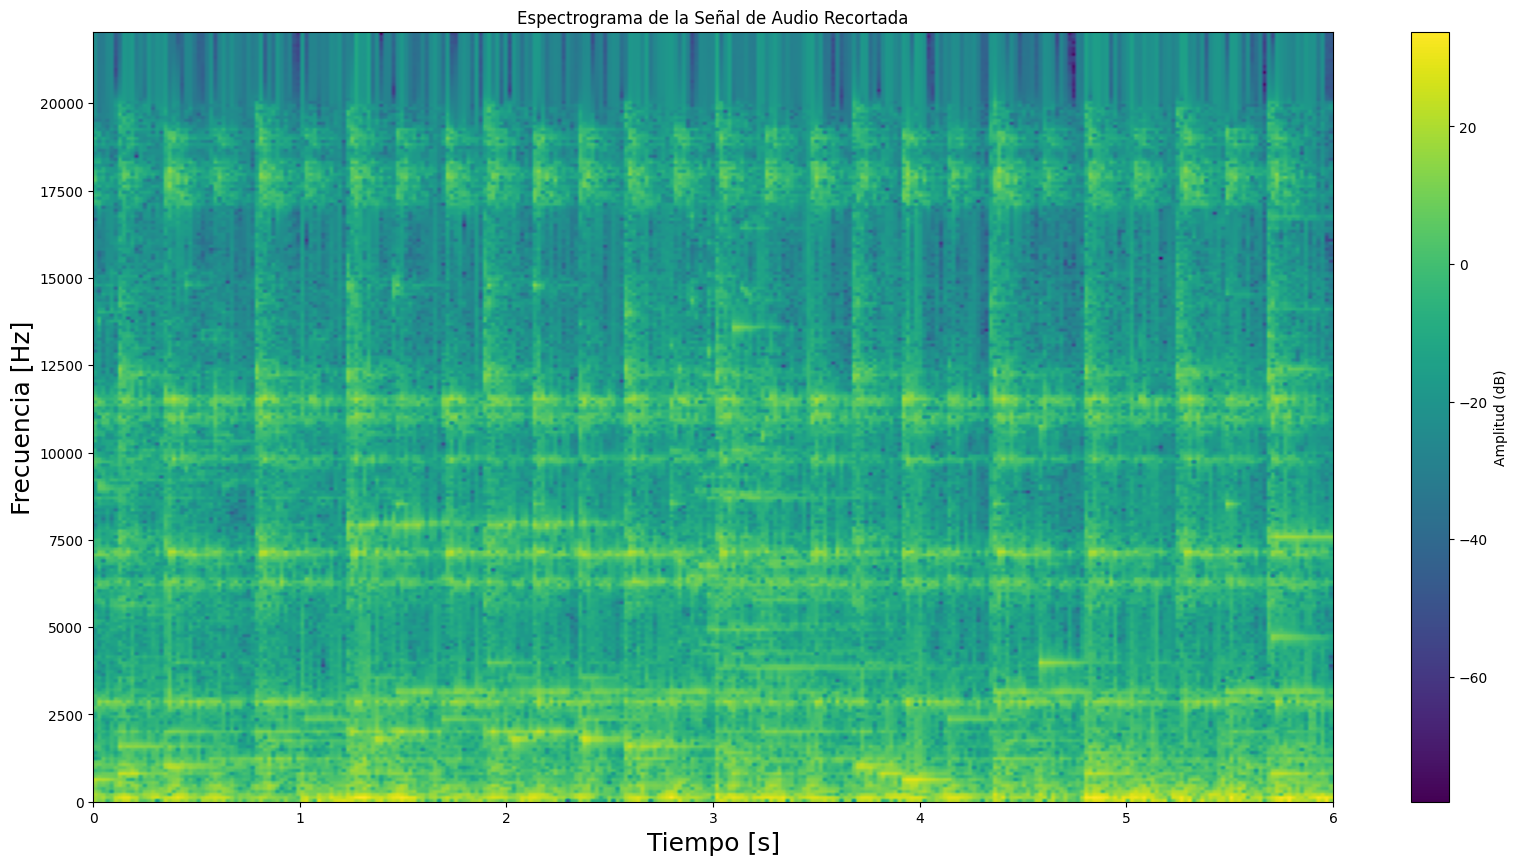

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import hamming

# Parámetros
N = 0.04  # Duración de la ventana en segundos
window_size = int(N * fs)  # Tamaño de la ventana
noverlap = window_size // 2
nfft = 512

# Crear la ventana de Hamming
ventana_hamming = hamming(window_size)

# Visualizar la ventana de Hamming
plt.figure(figsize=(8, 4))
plt.plot(ventana_hamming)
plt.title('Ventana Hamming')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

# Dividir la señal en ventanas y aplicar la ventana de Hamming
num_segments = (len(audio_recortado) - window_size) // noverlap + 1
ventanas = np.array([audio_recortado[i * noverlap:i * noverlap + window_size] for i in range(num_segments)])
hamming_aplicado = ventanas * ventana_hamming

# Definir la función potspec
def potspec(X, size, n_padded_min=0):

    # Zero padding para la próxima potencia de 2
    if n_padded_min == 0:
        n_padded = max(size, int(2 ** np.ceil(np.log(size) / np.log(2))))
    else:
        n_padded = n_padded_min
    
    # Transformada de Fourier
    Y = np.fft.fft(X, n=n_padded)
    Y = np.absolute(Y)
    
    # Parte no redundante
    m = int(n_padded / 2) + 1
    Y = Y[:, :m]
    
    return np.abs(Y) ** 2, n_padded

# Calcular el espectro de potencia para cada segmento con ventana aplicada
espectro, nfft = potspec(hamming_aplicado, window_size, n_padded_min=nfft)
espectro = np.flipud(10 * np.log10(espectro).T)

# Visualizar el espectrograma
plt.figure(figsize=(20, 10))
plt.title('Espectrograma de la Señal de Audio Recortada')
plt.imshow(espectro, aspect='auto', extent=[0, len(audio_recortado) / fs, 0, fs // 2], cmap='viridis')
plt.ylabel('Frecuencia [Hz]', fontsize=18)
plt.xlabel('Tiempo [s]', fontsize=18)
plt.colorbar(label='Amplitud (dB)')
plt.show()


### Diseño de Filtro FIR Pasa-Bajas en Python

#### Introducción

Los filtros FIR (Finite Impulse Response) son filtros digitales que tienen una respuesta de impulso de duración finita. Estos filtros se caracterizan por su estabilidad y por tener una respuesta lineal de fase, lo cual los hace ideales para muchas aplicaciones en procesamiento de señales.

En este notebook, diseñamos un filtro FIR pasa-bajas utilizando Python. Un filtro pasa-bajas es un filtro que permite el paso de frecuencias por debajo de una frecuencia de corte específica y atenúa las frecuencias por encima de esta frecuencia.

#### Teoría del Filtro FIR Pasa-Bajas

**Se diseña un Filtro Pasa-Bajos por medio de la técnica del enventanado teniendo en cuenta las siguientes características:**

$$
B_w = \Delta w = 350 \, \text{Hz} \quad f_c = 6 \, \text{kHz}
$$

$$
\text{Ripple} = 0.4\%
$$

**por lo que realizamos el siguiente análisis: Se tiene que el ripple está representado con el símbolo delta**

$$
\text{Ripple} = \delta
$$

**y expresado en porcentaje por lo que tiene que su valor es**

$$
\delta = \frac{0.4\%}{100\%} = 0.004
$$

**y debemos hallar su valor expresado en dB**

$$
\delta_{dB} = 20 \cdot \log_{10}(\delta) = 20 \cdot \log_{10}(0.004) \approx -48 \, \text{dB}
$$

**Luego comparamos el valor hallado con la tabla de valores que nos dice segun el Ripple cual es la ventana más propicia para filtrar la señal; en este caso usaremos Hamming**

**Hamming:**

$$
\frac{8 \pi}{M} \leq \frac{2 \pi \Delta f_m}{f_s}
$$

**por lo que se obtiene que el orden del filtro es el siguiente:**

$$
M \geq \frac{8 \pi f_s}{2 \pi \Delta f_m} \geq 504
$$

**pero para que el filtro pueda tener fase lineal al generarlo de forma causal y simetría par es necesario que sea impar:**

$$
M = 505
$$

**Diseño del Filtro**

**Pasa-bajas**

$$
h_i[n] = \begin{cases} 
\frac{\omega_c}{\pi} \cdot \frac{\sin(\omega_c n)}{\omega_c n} = \frac{2 f_c \sin(n \omega_c)}{\omega_c n} & \text{si } n \neq 0 \\ 
\frac{\omega_c}{\pi} = 2 f_c & \text{si } n = 0 
\end{cases} 
$$


La implementación práctica de esta respuesta ideal se logra mediante la convolución con una ventana de Hamming:

$$ w[n] = 0.54 - 0.46 \cos \left( \frac{2\pi n}{N-1} \right) $$

Finalmente, los coeficientes del filtro FIR se calculan como:

$$ h[n] = h_d[n] \cdot w[n] $$

### Parámetros del Filtro FIR Pasa-Bajas

Definimos los parámetros básicos para nuestro filtro FIR pasa-bajas:

- `fs`: Frecuencia de muestreo (en Hz).
- `fc`: Frecuencia de corte (en Hz).
- `M`: Número de coeficientes del filtro (orden del filtro).
- `nyq_rate`: Frecuencia de Nyquist (la mitad de la frecuencia de muestreo).

**Frecuencia de Muestreo (\( f_s \))**

La frecuencia de muestreo, representada por \( f_s \), es la frecuencia a la cual se toman las muestras de una señal continua para convertirla en una señal digital. En este caso, hemos seleccionado una frecuencia de muestreo de 44,100 Hz calculada en el anterior filtro.

**Frecuencia de Corte (\( f_c \))**

La frecuencia de corte, representada por \( f_c \), es la frecuencia en la cual el filtro comienza a atenuar las frecuencias superiores. Para nuestro filtro pasa-bajas, hemos seleccionado una frecuencia de corte de 6,000 Hz:

Esto significa que el filtro permitirá el paso de frecuencias por debajo de 6,000 Hz y atenuará las frecuencias por encima de 6,000 Hz. La selección de la frecuencia de corte depende de la aplicación específica y de las características de la señal que , nuestro objetivo para este caso es escuchar diferentes tonos de la señal de audioueremos procesar.

**Número de Coeficientes del Filtro (\( M \))**

El número de coeficientes del filtro, también conocido como el orden del filtro, determina la cantidad de términos en la suma que define el filtro FIR. En este caso, hemos seleccionado un orden de 505:

**Frecuencia de Nyquist (\( \text{nyq_rate} \))**

En este caso, la frecuencia de Nyquist es 22,050 Hz. La frecuencia de Nyquist es importante porque, según el teorema de muestreo de Nyquist, una señal debe ser muestreada a una tasa de al menos el doble de su frecuencia máxima para evitar el aliasing.



### Diseño del Filtro FIR Pasa-Bajas

Usamos la función `firwin` de `scipy.signal` para diseñar el filtro FIR pasa-bajas. Esta función genera los coeficientes del filtro basado en los parámetros definidos.

**Descripción del Código**

- `firwin`: Es una función de `scipy.signal` que diseña filtros FIR utilizando la técnica de ventanas.
- `M`: Es el número de coeficientes del filtro. Un mayor número de coeficientes proporciona una mayor precisión en la respuesta del filtro, pero a costa de un mayor costo computacional.
- `fc / nyq_rate`: Especifica la frecuencia de corte del filtro en términos de la frecuencia de Nyquist.
- `window='hamming'`: Especifica que se utilizará una ventana de Hamming para el diseño del filtro. Las ventanas se usan para controlar el ripple en la respuesta en frecuencia del filtro.


### Observaciones de la Gráfica de Coeficientes del Filtro FIR Pasa-Bajas

**Diferentes amplitudes en filtro Pasa-Bajas alrededor del coeficiente central**:

- En un filtro pasa-bajas, la respuesta es gradual. Los coeficientes a ambos lados del coeficiente central disminuyen gradualmente en magnitud, lo que ayuda a suavizar la transición entre las frecuencias bajas (que pasan) y las frecuencias altas (que se atenúan).
- La respuesta en frecuencia no tiene un corte brusco, sino que se atenúa gradualmente, lo que explica por qué los coeficientes tienen diferentes amplitudes.

**Simetría**:

- Los coeficientes son simétricos alrededor del punto central. Esto es una confirmación visual de que el filtro FIR tiene una respuesta en fase lineal.

**Coeficiente Central**:

- El coeficiente central tiene un valor significativamente mayor que los demás coeficientes. Este valor representa la contribución principal del filtro en la frecuencia de corte.
- Este coeficiente central elevado indica que el filtro permite el paso de frecuencias bajas, mientras que atenúa las frecuencias más altas.


**Respuesta en frecuencia del filtro**:

Para analizar la respuesta en frecuencia del filtro FIR pasa-bajas, utilizamos la función freqz de scipy.signal, que nos permite calcular y graficar la respuesta en frecuencia del filtro diseñado.

### Análisis de la Respuesta en Frecuencia del Filtro FIR Pasa-Bajas

La gráfica muestra la respuesta en frecuencia del filtro FIR pasa-bajas diseñado. A continuación, se presentan las observaciones clave:

#### Banda de Paso:

- La ganancia se mantiene cerca de 1 para frecuencias por debajo de aproximadamente 6,000 Hz. Esto indica que el filtro permite el paso de estas frecuencias con muy poca o ninguna atenuación, cumpliendo con su propósito de filtro pasa-bajas.
- La banda de paso es plana y estable, lo cual es una característica deseada en filtros pasa-bajas.

#### Banda de Atenuación:

- Para frecuencias por encima de 6,000 Hz, la ganancia disminuye abruptamente, acercándose a cero. Esto indica que el filtro atenúa estas frecuencias de manera efectiva, bloqueándolas casi por completo.
- La transición entre la banda de paso y la banda de atenuación no es completamente vertical, pero es lo suficientemente pronunciada como para confirmar que el filtro tiene un buen rendimiento.


### Aplicación del Filtro a la Señal de Audio

Para evaluar cómo el filtro FIR pasa-bajas afecta una señal de audio, aplicamos el filtro a una grabación de audio y comparamos las señales original y filtrada.

#### Pasos:

1. **Leer la señal de audio:** 
   Utilizamos la función `wavfile.read` para leer el archivo de audio `audio.wav`. Convertimos la señal de audio a tipo `float32` para asegurarnos de que esté en el formato adecuado para el procesamiento.

2. **Aplicar el filtro a la señal:** 
   Utilizamos la función `lfilter` de `scipy.signal` para aplicar el filtro FIR pasa-bajas a la señal de audio.

3. **Visualizar las señales original y filtrada:** 
   Graficamos las señales original y filtrada para comparar visualmente los efectos del filtrado.


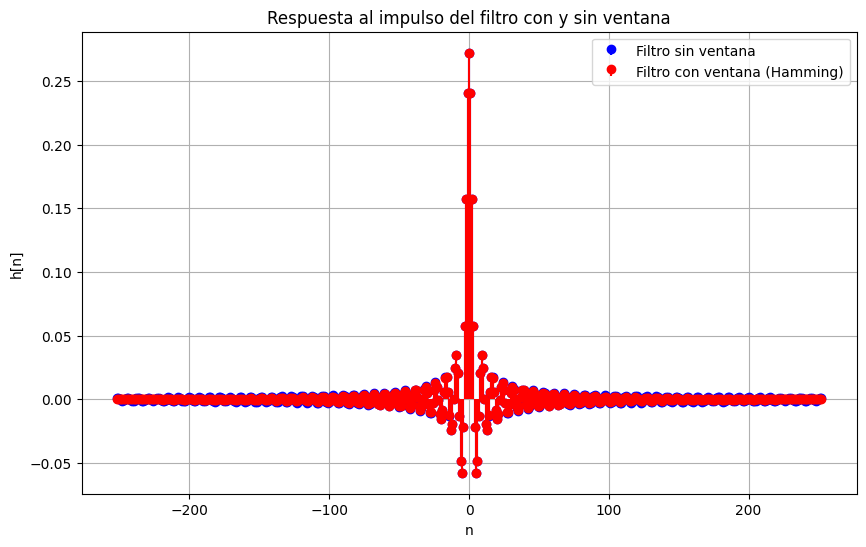

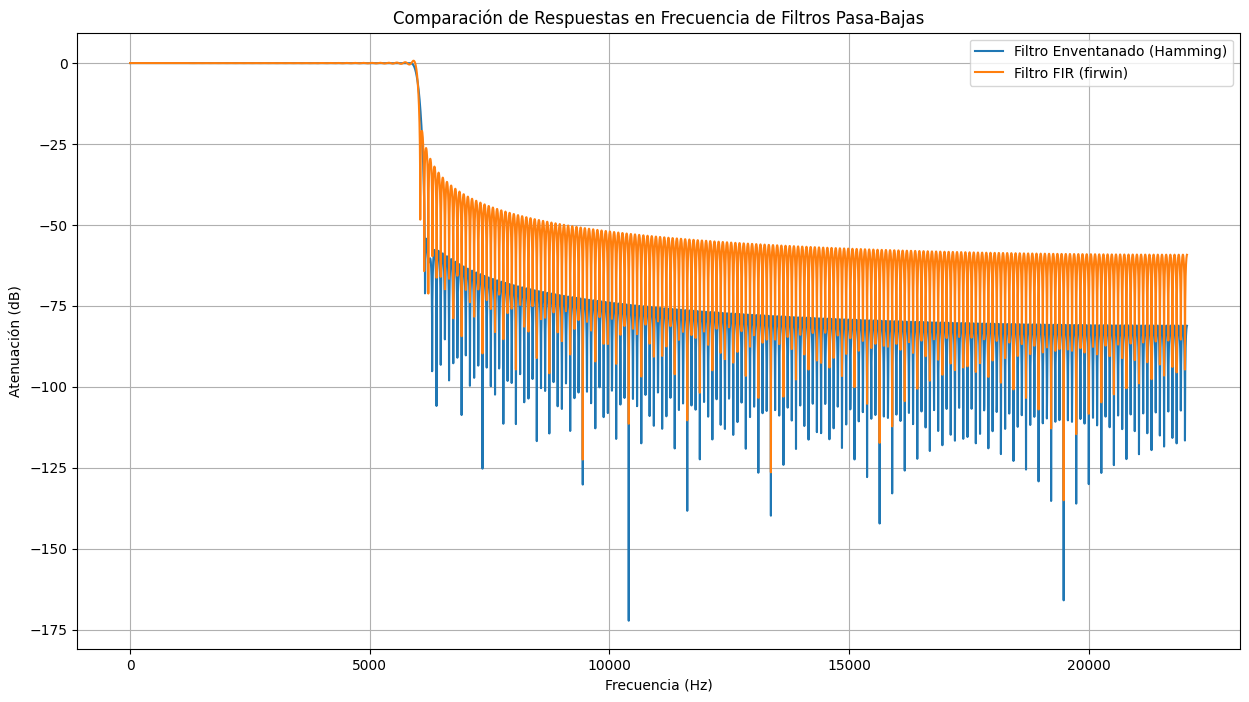

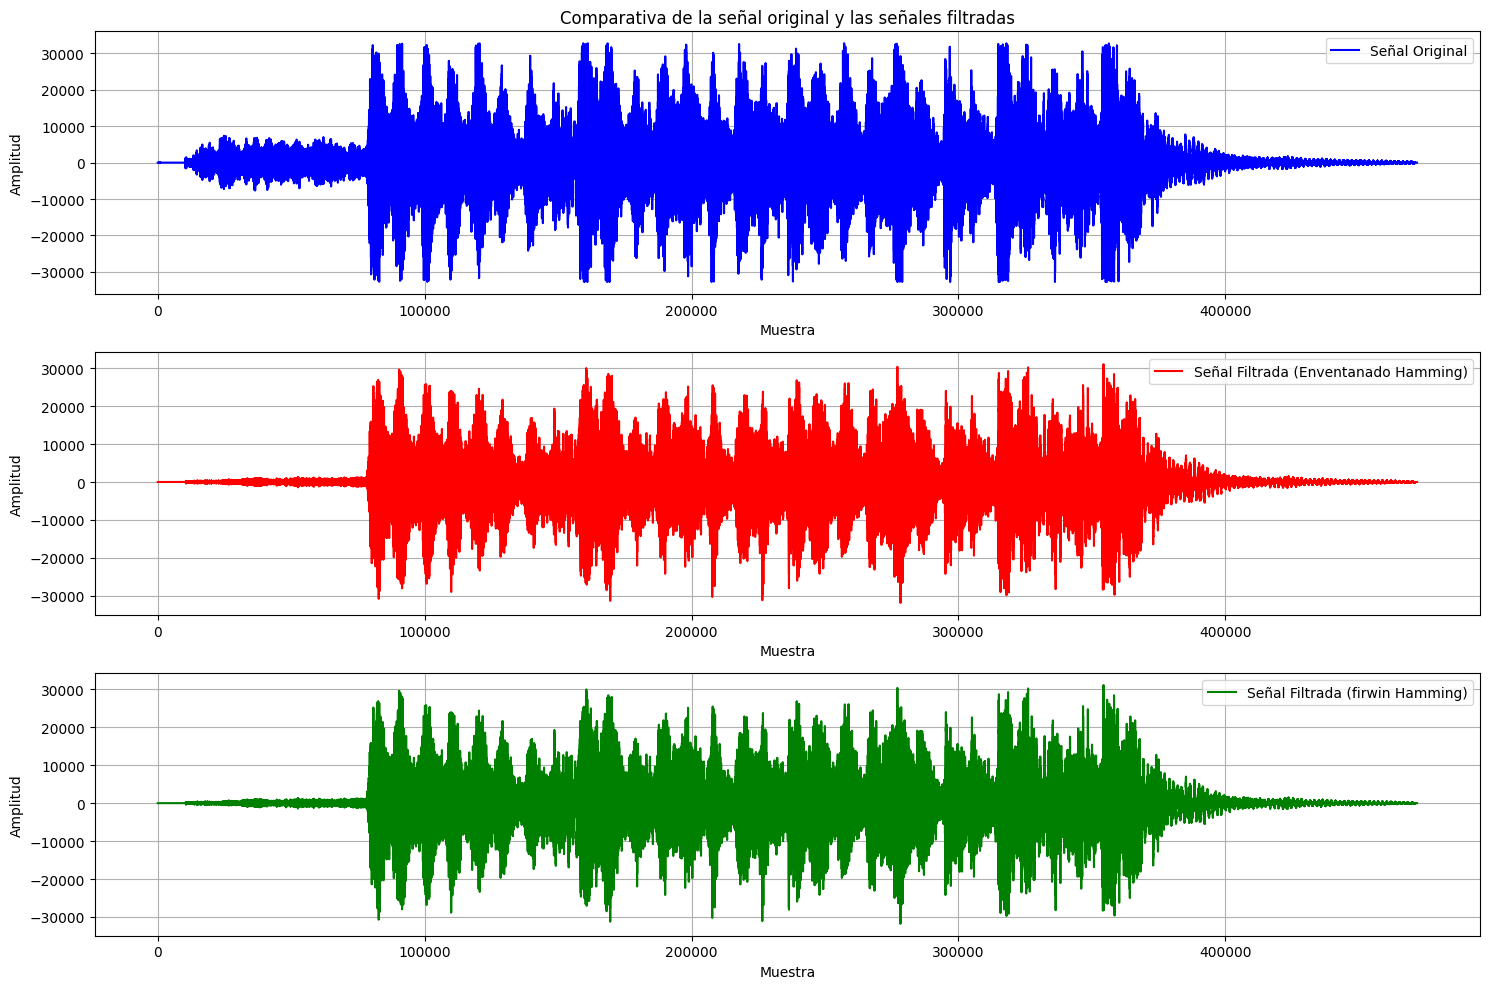

Coeficiente de correlación (Pasabajas): 1.0000


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, lfilter, firwin
from scipy.io import wavfile

# Leer la señal de audio (asegúrate de tener el archivo 'audio.wav' en el directorio de trabajo)
rate, audio = wavfile.read('audio.wav')
audio = audio.astype(np.float32)

# Parámetros del filtro
fs = 44100.0
BW = 350.0  # ancho de banda
bwn = 2 * np.pi * (BW / fs)  # ancho de banda normalizada
fc = 6000.0  # frecuencia de corte
fc_norm = fc / fs  # frecuencia de corte normalizada
wc = 2 * np.pi * (fc / fs)  # frecuencia angular normalizada
delta = 0.004  # ripple
delta_dB = -48  # ripple en dB
M = 505  # orden del filtro

n = np.arange(-M // 2 + 1, M // 2 + 1)

# Generar la ecuación del filtro
hi_n = np.zeros_like(n, dtype=float)
for i, ni in enumerate(n):
    if ni == 0:
        hi_n[i] = 2 * fc_norm
    else:
        hi_n[i] = 2 * fc_norm * (np.sin(wc * ni) / (wc * ni))

# Generar la ecuación del enventanado (Hamming)
wn = np.array([0.54 - 0.46 * np.cos(2 * np.pi * k / (M - 1)) for k in range(M)])

# Filtro final enventanado
H_n = hi_n * wn

# Calcular la respuesta en frecuencia del filtro enventanado
w, h = freqz(H_n, worN=8000)

# Graficar el filtro y el enventanado
plt.figure(figsize=(10, 6))
plt.stem(n, hi_n, basefmt=" ", linefmt='b-', markerfmt='bo', label='Filtro sin ventana')
plt.stem(n, H_n, basefmt=" ", linefmt='r-', markerfmt='ro', label='Filtro con ventana (Hamming)')
plt.title('Respuesta al impulso del filtro con y sin ventana')
plt.xlabel('n')
plt.ylabel('h[n]')
plt.legend()
plt.grid(True)
plt.show()

# Graficar la respuesta en frecuencia del filtro enventanado
plt.figure(figsize=(15, 8))
plt.plot(0.5 * fs * w / np.pi, 20 * np.log10(np.abs(h)), label='Filtro Enventanado (Hamming)')
plt.title('Comparación de Respuestas en Frecuencia de Filtros Pasa-Bajas')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Atenuación (dB)')
plt.grid(True)

# Diseño del filtro usando firwin
nyq_rate = fs / 2.0
taps = firwin(M, fc / nyq_rate, window='hamming', width=bwn/fs)

# Calcular la respuesta en frecuencia del filtro firwin
w_firwin, h_firwin = freqz(taps, worN=8000)

# Graficar la respuesta en frecuencia del filtro firwin
plt.plot(0.5 * fs * w_firwin / np.pi, 20 * np.log10(np.abs(h_firwin)), label='Filtro FIR (firwin)')

plt.legend()
plt.show()

# Aplicar ambos filtros al audio
audio_filtrado = lfilter(H_n, 1.0, audio)
audio_filtrado_firwin = lfilter(taps, 1.0, audio)

# Graficar la señal original y las señales filtradas
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(audio, 'b-', label='Señal Original')
plt.title('Comparativa de la señal original y las señales filtradas')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(audio_filtrado, 'r-', label='Señal Filtrada (Enventanado Hamming)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(audio_filtrado_firwin, 'g-', label='Señal Filtrada (firwin Hamming)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


wavfile.write('audio_filtrado_enventanado.wav', rate, audio_filtrado.astype(np.int16))
wavfile.write('audio_filtrado_firwin.wav', rate, audio_filtrado_firwin.astype(np.int16))

correlation_lp = np.corrcoef(audio_filtrado_firwin, audio_filtrado)[0, 1]
print(f'Coeficiente de correlación (Pasabajas): {correlation_lp:.4f}')

### Comparación en el Dominio de la Frecuencia

Para evaluar cómo el filtro FIR pasa-bajas afecta a la señal de audio en términos de su contenido frecuencial, calculamos y graficamos la Transformada de Fourier (FFT) de ambas señales: la señal original y la señal filtrada. Esta comparación nos permite observar cómo se modifican las componentes de frecuencia debido a la aplicación del filtro.

#### Pasos:

1. **Calcular la Transformada de Fourier (FFT):** 
   Utilizamos la función `np.fft.fft` de NumPy para calcular la FFT de la señal original y la señal filtrada.

2. **Calcular las frecuencias correspondientes:** 
   Utilizamos la función `np.fft.fftfreq` para obtener las frecuencias correspondientes a los puntos de la FFT.

3. **Graficar las transformadas:** 
   Graficamos la magnitud de la FFT para ambas señales para comparar visualmente los efectos del filtrado en el dominio de la frecuencia.


### Observaciones de la Comparación en el Dominio de la Frecuencia

**Banda de Paso:**

La gráfica muestra que la magnitud de la señal filtrada se mantiene casi igual a la de la señal original en las frecuencias por debajo de 6,000 Hz. Esto confirma que el filtro permite el paso de estas frecuencias sin mucha atenuación.

**Comparación General:**

La comparación de las FFTs de las señales original y filtrada demuestra visualmente cómo el filtro pasa-bajas modifica el contenido frecuencial de la señal de audio, preservando las frecuencias bajas y atenuando las frecuencias altas.


In [3]:
# Calcular el coeficiente de correlación entre la señal original y la señal filtrada
correlation_lp = np.corrcoef(audio, audio_filtrado_firwin)[0, 1]
print(f'Coeficiente de correlación (Pasabajas): {correlation_lp:.4f}')


correlation_lp = np.corrcoef(audio, audio_filtrado)[0, 1]
print(f'Coeficiente de correlación (Pasabajas): {correlation_lp:.4f}')

Coeficiente de correlación (Pasabajas): -0.4608
Coeficiente de correlación (Pasabajas): -0.4615


En este caso, un coeficiente de correlación de -0.4615 indica una correlación negativa moderada entre la señal original y la señal filtrada. Esto sugiere que el filtro ha modificado la señal original de manera significativa, lo cual es esperado ya que el filtro pasa-bajas está diseñado para eliminar componentes de frecuencia alta, afectando la estructura original de la señal de manera notable.

### Diseño de Filtro FIR Rechaza-Banda en Python

#### Introducción

Los filtros FIR (Finite Impulse Response) son filtros digitales que tienen una respuesta de impulso de duración finita. Estos filtros se caracterizan por su estabilidad y por tener una respuesta lineal de fase, lo cual los hace ideales para muchas aplicaciones en procesamiento de señales.

En este notebook, diseñamos un filtro FIR rechaza-banda utilizando Python. Un filtro rechaza-banda es un filtro que atenúa las frecuencias dentro de una banda específica y permite el paso de las frecuencias fuera de esta banda.

#### Teoría del Filtro FIR Rechaza-Banda

**Se diseña un Filtro Rechaza-Banda por medio de la técnica del enventanado teniendo en cuenta las siguientes características:**

$$
B_w = \Delta w = 350 \, \text{Hz} \quad f_{c1} = 4 \, \text{kHz} \quad f_{c2} = 6 \, \text{kHz}
$$

$$
\text{Ripple} = 0.4\%
$$

**por lo que realizamos el siguiente análisis: Se tiene que el ripple está representado con el símbolo delta**

$$
\text{Ripple} = \delta
$$

**y expresado en porcentaje por lo que tiene que su valor es**

$$
\delta = \frac{0.4\%}{100\%} = 0.004
$$

**y debemos hallar su valor expresado en dB**

$$
\delta_{dB} = 20 \cdot \log_{10}(\delta) = 20 \cdot \log_{10}(0.004) \approx -48 \, \text{dB}
$$

**Luego comparamos el valor hallado con la tabla de valores que nos dice según el Ripple cuál es la ventana más propicia para filtrar la señal; en este caso usaremos Hamming**

**Hamming:**

$$
\frac{8 \pi}{M} \leq \frac{2 \pi \Delta f_m}{f_s}
$$

**por lo que se obtiene que el orden del filtro es el siguiente:**

$$
M \geq \frac{8 \pi f_s}{2 \pi \Delta f_m} \geq 504
$$

**pero para que el filtro pueda tener fase lineal al generarlo de forma causal y simetría par es necesario que sea impar:**

$$
M = 505
$$

**Diseño del Filtro**

**Rechaza-Banda**

$$
h_i[n] = \begin{cases} 
\frac{\sin(\omega_{c1} n)}{\pi n} - \frac{\sin(\omega_{c2} n)}{\pi n} & \text{si } n \neq 0 \\ 
1 - 2(f_{c2} - f_{c1}) & \text{si } n = 0 
\end{cases} 
$$

La implementación práctica de esta respuesta ideal se logra mediante la convolución con una ventana de Hamming:

$$ w[n] = 0.54 - 0.46 \cos \left( \frac{2\pi n}{N-1} \right) $$

Finalmente, los coeficientes del filtro FIR se calculan como:

$$ h[n] = h_d[n] \cdot w[n] $$


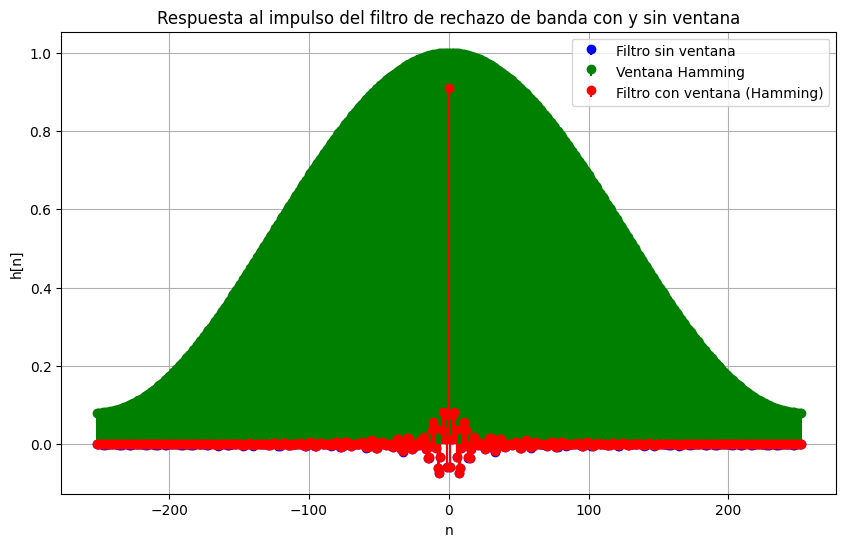

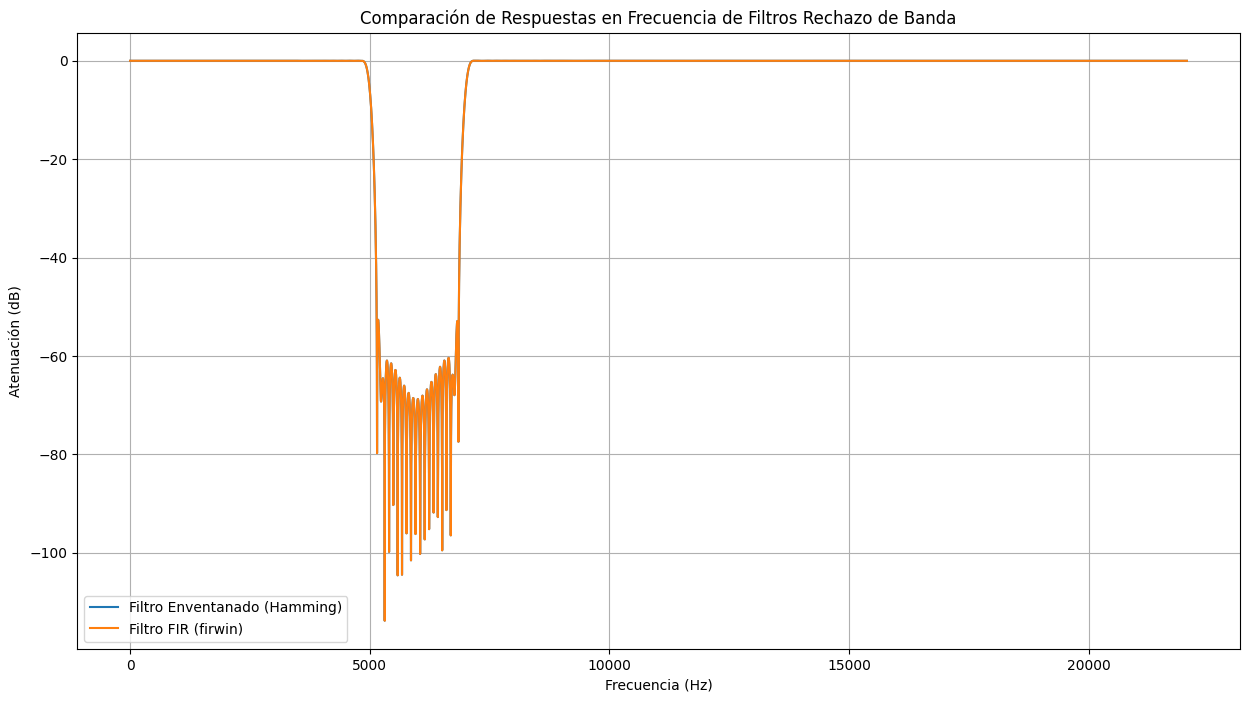

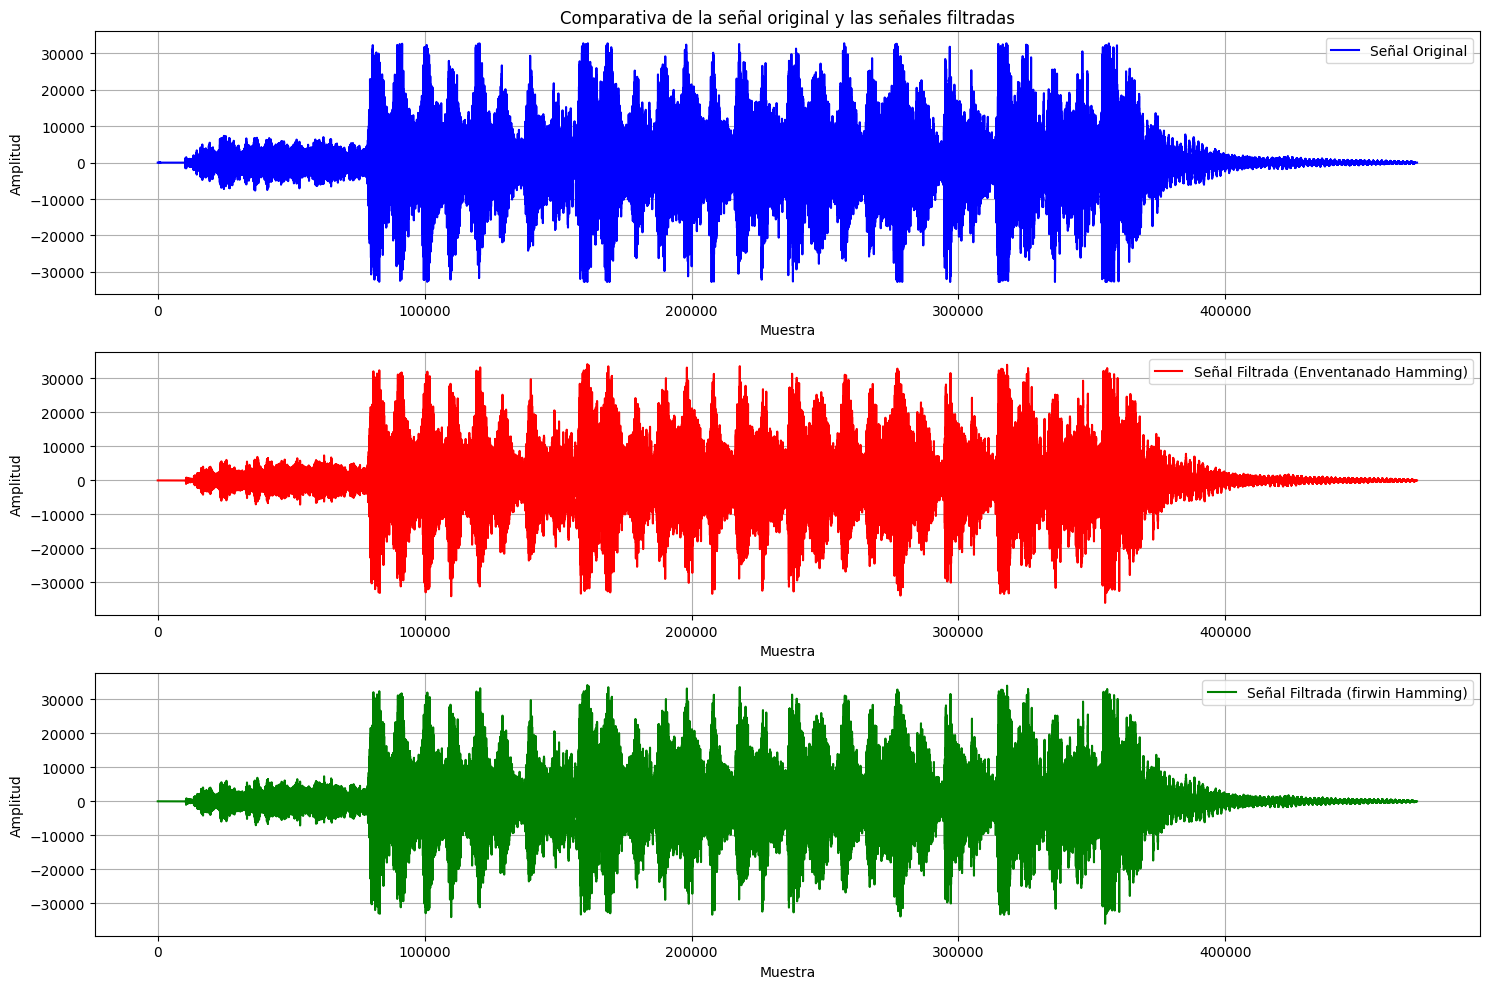

Ver los primeros valores del filtro para verificar H_n=  [-4.38442805e-05  1.11705878e-04  1.77525768e-04  1.17274523e-04
 -7.74034964e-06 -9.73811109e-05 -9.74557292e-05 -3.63266894e-05
  1.43226526e-05  1.28969028e-05]
Ver los primeros valores del filtro firwin=  [-4.38273423e-05  1.11662723e-04  1.77457185e-04  1.17229217e-04
 -7.73735933e-06 -9.73434899e-05 -9.74180794e-05 -3.63126554e-05
  1.43171193e-05  1.28919203e-05]
Ver los primeros valores del vector de muestras n=  [-252 -251 -250 -249 -248 -247 -246 -245 -244 -243]
Ver los primeros valores del enventanado de Hamming 
 W[n]=  [0.08       0.08003575 0.08014298 0.08032168 0.08057182 0.08089336
 0.08128625 0.08175044 0.08228584 0.08289238]
Coeficiente de correlación (Pasabajas): -0.4305
Coeficiente de correlación (Pasabajas): -0.4305
Coeficiente de correlación (Pasabajas): 1.0000


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, lfilter, firwin
from scipy.io import wavfile

# Leer la señal de audio (asegúrate de tener el archivo 'audio.wav' en el directorio de trabajo)
rate, audio = wavfile.read('audio.wav')
audio = audio.astype(np.float32)

# Parámetros del filtro
fs = 44100.0
BW = 350.0  # ancho de banda
bwn = 2 * np.pi * (BW / fs)  # ancho de banda normalizada
fc1 = 5000.0  # frecuencia de corte baja
fc2 = 7000.0  # frecuencia de corte alta
fc1_norm = fc1 / fs  # frecuencia de corte normalizada baja
fc2_norm = fc2 / fs  # frecuencia de corte normalizada alta
wc1 = 2 * np.pi * (fc1 / fs)  # frecuencia angular normalizada baja
wc2 = 2 * np.pi * (fc2 / fs)  # frecuencia angular normalizada alta
delta = 0.004  # ripple
delta_dB = -48  # ripple en dB
M = 505  # orden del filtro

n = np.arange(-M // 2 + 1, M // 2 + 1)

# Generar la ecuación del filtro rechazo de banda
hi_n = np.zeros_like(n, dtype=float)
for i, ni in enumerate(n):
    if ni == 0:
        hi_n[i] = 1 - 2 * (fc2_norm - fc1_norm)
    else:
        hi_n[i] = (np.sin(wc1 * ni) / (np.pi * ni)) - (np.sin(wc2 * ni) / (np.pi * ni))

# Generar la ecuación del enventanado (Hamming)
wn = np.array([0.54 - 0.46 * np.cos(2 * np.pi * k / (M - 1)) for k in range(M)])

# Filtro final enventanado
H_n = hi_n * wn

# Calcular la respuesta en frecuencia del filtro enventanado
w, h = freqz(H_n, worN=8000)

# Graficar el filtro, la ventana y el filtro con ventana
plt.figure(figsize=(10, 6))
plt.stem(n, hi_n, basefmt=" ", linefmt='b-', markerfmt='bo', label='Filtro sin ventana')
plt.stem(n, wn, basefmt=" ", linefmt='g-', markerfmt='go', label='Ventana Hamming')
plt.stem(n, H_n, basefmt=" ", linefmt='r-', markerfmt='ro', label='Filtro con ventana (Hamming)')
plt.title('Respuesta al impulso del filtro de rechazo de banda con y sin ventana')
plt.xlabel('n')
plt.ylabel('h[n]')
plt.legend()
plt.grid(True)
plt.show()

# Graficar la respuesta en frecuencia del filtro enventanado
plt.figure(figsize=(15, 8))
plt.plot(0.5 * fs * w / np.pi, 20 * np.log10(np.abs(h)), label='Filtro Enventanado (Hamming)')
plt.title('Comparación de Respuestas en Frecuencia de Filtros Rechazo de Banda')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Atenuación (dB)')
plt.grid(True)

# Diseño del filtro de rechazo de banda usando firwin
nyq_rate = fs / 2.0
taps = firwin(M, [fc1 / nyq_rate, fc2 / nyq_rate], pass_zero='bandstop', window='hamming')

# Calcular la respuesta en frecuencia del filtro firwin
w_firwin, h_firwin = freqz(taps, worN=8000)

# Graficar la respuesta en frecuencia del filtro firwin
plt.plot(0.5 * fs * w_firwin / np.pi, 20 * np.log10(np.abs(h_firwin)), label='Filtro FIR (firwin)')

plt.legend()
plt.show()

# Aplicar ambos filtros al audio
audio_filtrado = lfilter(H_n, 1.0, audio)
audio_filtrado_firwin = lfilter(taps, 1.0, audio)

# Graficar la señal original y las señales filtradas
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(audio, 'b-', label='Señal Original')
plt.title('Comparativa de la señal original y las señales filtradas')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(audio_filtrado, 'r-', label='Señal Filtrada (Enventanado Hamming)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(audio_filtrado_firwin, 'g-', label='Señal Filtrada (firwin Hamming)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Guardar los archivos de audio filtrados
wavfile.write('audio_filtrado_enventanado.wav', rate, audio_filtrado.astype(np.int16))
wavfile.write('audio_filtrado_firwin.wav', rate, audio_filtrado_firwin.astype(np.int16))

# Ver los primeros valores del vector de muestras
print("Ver los primeros valores del filtro para verificar H_n= ", H_n[:10])
print("Ver los primeros valores del filtro firwin= ", taps[:10])

# Ver los primeros valores del vector de muestras
print("Ver los primeros valores del vector de muestras n= ", n[:10])

print("Ver los primeros valores del enventanado de Hamming \n W[n]= ", wn[:10])


# Calcular el coeficiente de correlación entre la señal original y la señal filtrada
correlation_lp = np.corrcoef(audio, audio_filtrado_firwin)[0, 1]
print(f'Coeficiente de correlación (Pasabajas): {correlation_lp:.4f}')


correlation_lp = np.corrcoef(audio, audio_filtrado)[0, 1]
print(f'Coeficiente de correlación (Pasabajas): {correlation_lp:.4f}')

correlation_lp = np.corrcoef(audio_filtrado_firwin, audio_filtrado)[0, 1]
print(f'Coeficiente de correlación (Pasabajas): {correlation_lp:.4f}')

#### Teoría del Filtro FIR Pasa-Altas

**Se diseña un Filtro Pasa-Altas por medio de la técnica del enventanado teniendo en cuenta las siguientes características:**

$$
B_w = \Delta w = 350 \, \text{Hz} \quad f_c = 6 \, \text{kHz}
$$

$$
\text{Ripple} = 0.4\%
$$

**por lo que realizamos el siguiente análisis: Se tiene que el ripple está representado con el símbolo delta**

$$
\text{Ripple} = \delta
$$

**y expresado en porcentaje por lo que tiene que su valor es**

$$
\delta = \frac{0.4\%}{100\%} = 0.004
$$

**y debemos hallar su valor expresado en dB**

$$
\delta_{dB} = 20 \cdot \log_{10}(\delta) = 20 \cdot \log_{10}(0.004) \approx -48 \, \text{dB}
$$

**Luego comparamos el valor hallado con la tabla de valores que nos dice según el Ripple cuál es la ventana más propicia para filtrar la señal; en este caso usaremos Hamming**

**Hamming:**

$$
\frac{8 \pi}{M} \leq \frac{2 \pi \Delta f_m}{f_s}
$$

**por lo que se obtiene que el orden del filtro es el siguiente:**

$$
M \geq \frac{8 \pi f_s}{2 \pi \Delta f_m} \geq 504
$$

**pero para que el filtro pueda tener fase lineal al generarlo de forma causal y simetría par es necesario que sea impar:**

$$
M = 505
$$

**Diseño del Filtro**

**Pasa-altas**

$$
h_i[n] = \begin{cases} 
-\frac{\omega_c}{\pi} \cdot \frac{\sin(\omega_c n)}{\omega_c n} = -\frac{2 f_c \sin(n \omega_c)}{\omega_c n} & \text{si } n \neq 0 \\ 
1 - \frac{\omega_c}{\pi} = 1 - 2 f_c & \text{si } n = 0 
\end{cases} 
$$

La implementación práctica de esta respuesta ideal se logra mediante la convolución con una ventana de Hamming:

$$ w[n] = 0.54 - 0.46 \cos \left( \frac{2\pi n}{N-1} \right) $$

Finalmente, los coeficientes del filtro FIR se calculan como:

$$ h[n] = h_d[n] \cdot w[n] $$


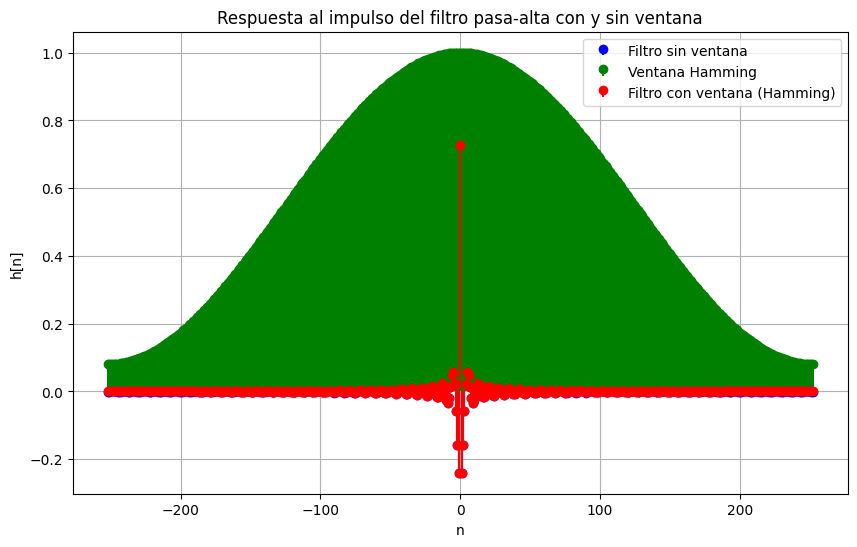

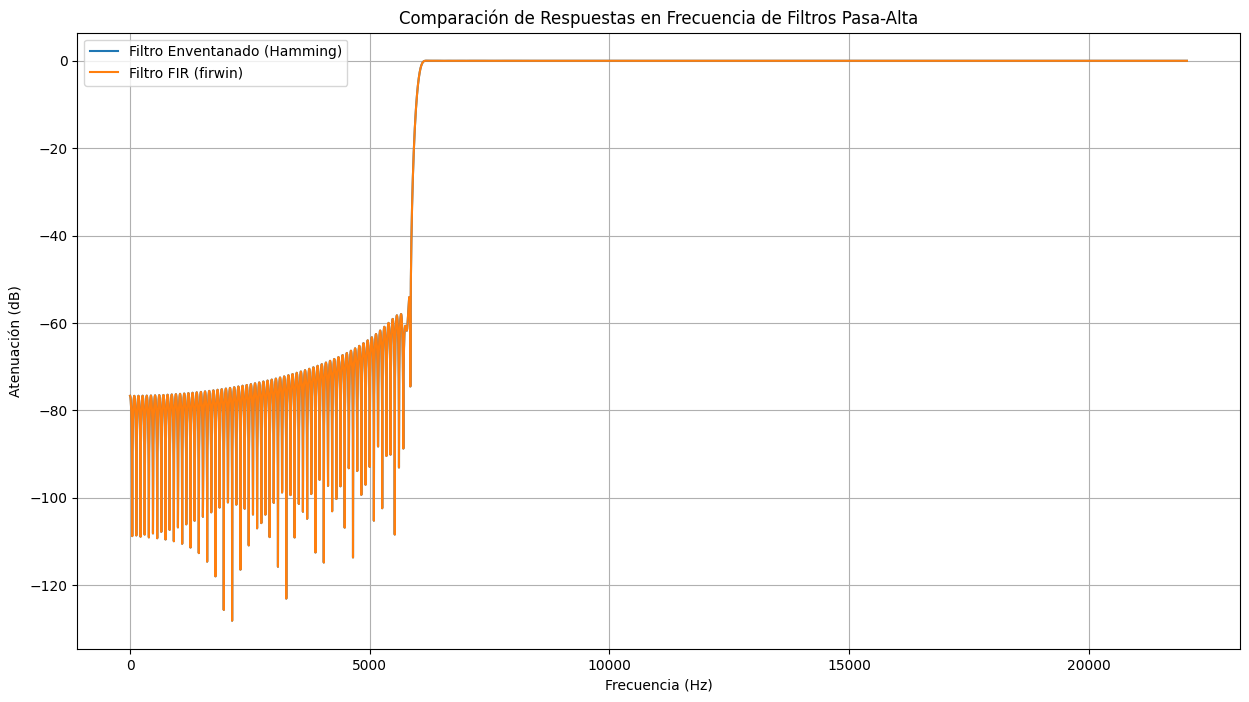

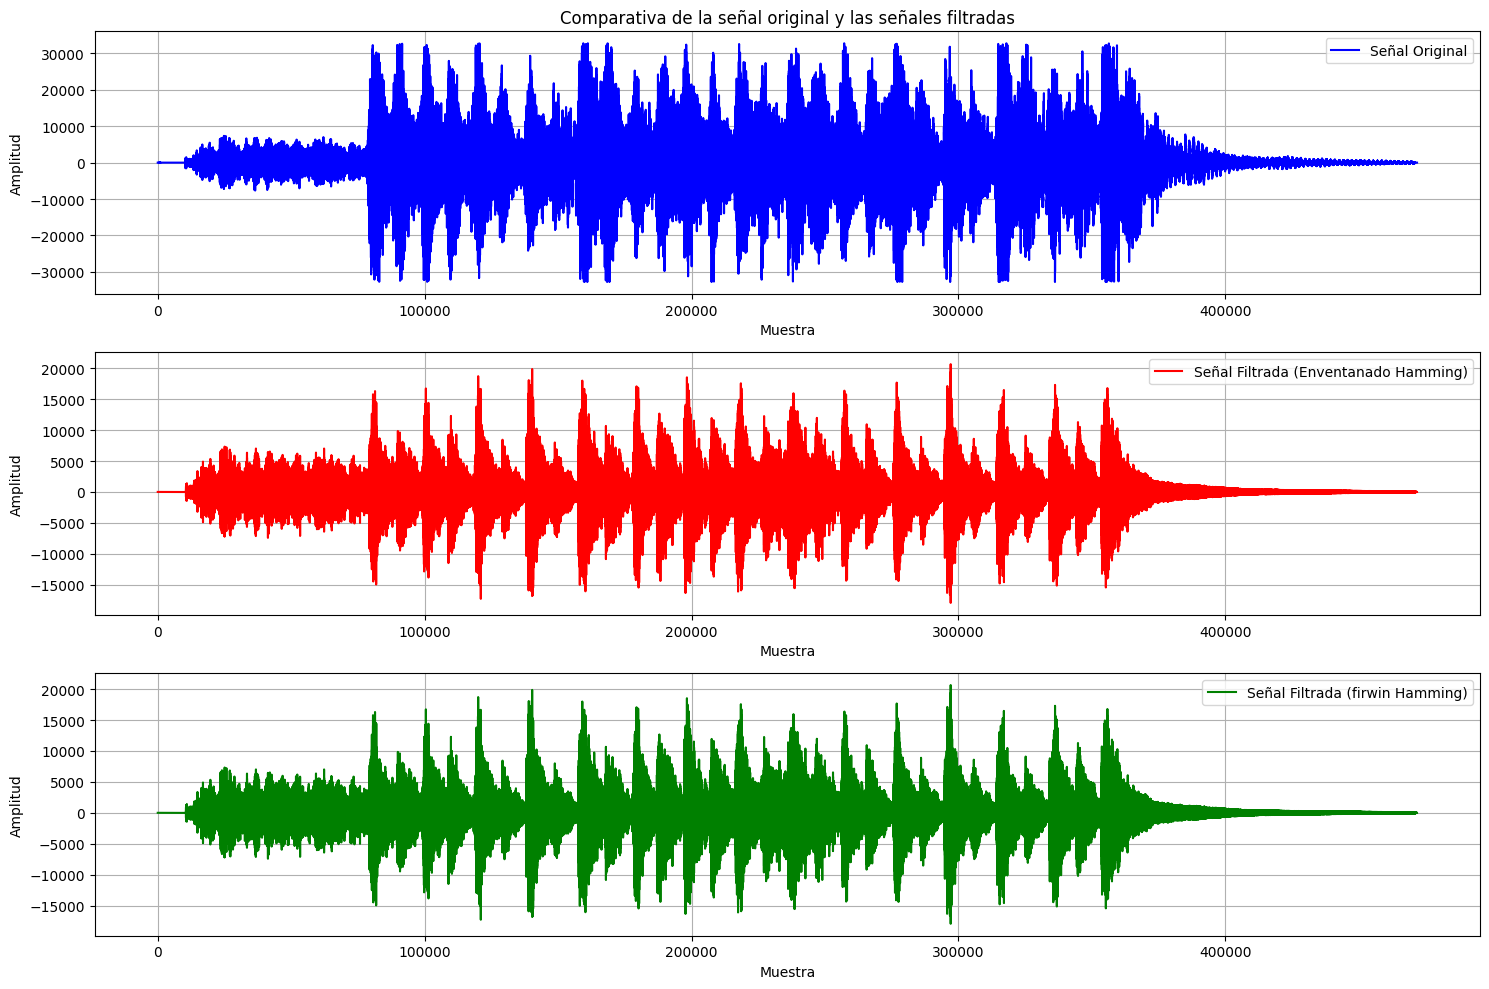

Ver los primeros valores del filtro para verificar H_n=  [-9.85172041e-05 -8.19864703e-05 -8.71242458e-06  7.14323029e-05
  1.03266971e-04  6.41226908e-05 -2.01060164e-05 -9.19824065e-05
 -1.01509976e-04 -4.07473024e-05]
Ver los primeros valores del filtro firwin=  [-9.85258784e-05 -8.19936892e-05 -8.71319170e-06  7.14385924e-05
  1.03276063e-04  6.41283367e-05 -2.01077867e-05 -9.19905054e-05
 -1.01518914e-04 -4.07508901e-05]
Ver los primeros valores del vector de muestras n=  [-252 -251 -250 -249 -248 -247 -246 -245 -244 -243]
Ver los primeros valores del enventanado de Hamming 
 W[n]=  [0.08       0.08003575 0.08014298 0.08032168 0.08057182 0.08089336
 0.08128625 0.08175044 0.08228584 0.08289238]
Coeficiente de correlación (Pasabajas): 0.0160
Coeficiente de correlación (Pasabajas): 0.0160
Coeficiente de correlación (Pasabajas): 1.0000


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz, lfilter, firwin
from scipy.io import wavfile

# Leer la señal de audio (asegúrate de tener el archivo 'audio.wav' en el directorio de trabajo)
rate, audio = wavfile.read('audio.wav')
audio = audio.astype(np.float32)

# Parámetros del filtro
fs = 44100.0
BW = 350.0  # ancho de banda
bwn = 2 * np.pi * (BW / fs)  # ancho de banda normalizada
fc = 6000.0  # frecuencia de corte
fc_norm = fc / fs  # frecuencia de corte normalizada
wc = 2 * np.pi * (fc / fs)  # frecuencia angular normalizada
delta = 0.004  # ripple
delta_dB = -48  # ripple en dB
M = 505  # orden del filtro

n = np.arange(-M // 2 + 1, M // 2 + 1)

# Generar la ecuación del filtro pasa-alta
hi_n = np.zeros_like(n, dtype=float)
for i, ni in enumerate(n):
    if ni == 0:
        hi_n[i] = 1 - 2 * fc_norm
    else:
        hi_n[i] = -2 * fc_norm * (np.sin(wc * ni) / (wc * ni))

# Generar la ecuación del enventanado (Hamming)
wn = np.array([0.54 - 0.46 * np.cos(2 * np.pi * k / (M - 1)) for k in range(M)])

# Filtro final enventanado
H_n = hi_n * wn

# Calcular la respuesta en frecuencia del filtro enventanado
w, h = freqz(H_n, worN=8000)

# Graficar el filtro, la ventana y el filtro con ventana
plt.figure(figsize=(10, 6))
plt.stem(n, hi_n, basefmt=" ", linefmt='b-', markerfmt='bo', label='Filtro sin ventana')
plt.stem(n, wn, basefmt=" ", linefmt='g-', markerfmt='go', label='Ventana Hamming')
plt.stem(n, H_n, basefmt=" ", linefmt='r-', markerfmt='ro', label='Filtro con ventana (Hamming)')
plt.title('Respuesta al impulso del filtro pasa-alta con y sin ventana')
plt.xlabel('n')
plt.ylabel('h[n]')
plt.legend()
plt.grid(True)
plt.show()

# Graficar la respuesta en frecuencia del filtro enventanado
plt.figure(figsize=(15, 8))
plt.plot(0.5 * fs * w / np.pi, 20 * np.log10(np.abs(h)), label='Filtro Enventanado (Hamming)')
plt.title('Comparación de Respuestas en Frecuencia de Filtros Pasa-Alta')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Atenuación (dB)')
plt.grid(True)

# Diseño del filtro pasa-alta usando firwin
nyq_rate = fs / 2.0
taps = firwin(M, fc / nyq_rate, pass_zero=False, window='hamming')

# Calcular la respuesta en frecuencia del filtro firwin
w_firwin, h_firwin = freqz(taps, worN=8000)

# Graficar la respuesta en frecuencia del filtro firwin
plt.plot(0.5 * fs * w_firwin / np.pi, 20 * np.log10(np.abs(h_firwin)), label='Filtro FIR (firwin)')

plt.legend()
plt.show()

# Aplicar ambos filtros al audio
audio_filtrado = lfilter(H_n, 1.0, audio)
audio_filtrado_firwin = lfilter(taps, 1.0, audio)

# Graficar la señal original y las señales filtradas
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(audio, 'b-', label='Señal Original')
plt.title('Comparativa de la señal original y las señales filtradas')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(audio_filtrado, 'r-', label='Señal Filtrada (Enventanado Hamming)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(audio_filtrado_firwin, 'g-', label='Señal Filtrada (firwin Hamming)')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Guardar los archivos de audio filtrados
wavfile.write('audio_filtrado_enventanado.wav', rate, audio_filtrado.astype(np.int16))
wavfile.write('audio_filtrado_firwin.wav', rate, audio_filtrado_firwin.astype(np.int16))

# Ver los primeros valores del vector de muestras
print("Ver los primeros valores del filtro para verificar H_n= ", H_n[:10])
print("Ver los primeros valores del filtro firwin= ", taps[:10])

# Ver los primeros valores del vector de muestras
print("Ver los primeros valores del vector de muestras n= ", n[:10])

print("Ver los primeros valores del enventanado de Hamming \n W[n]= ", wn[:10])



# Calcular el coeficiente de correlación entre la señal original y la señal filtrada
correlation_lp = np.corrcoef(audio, audio_filtrado_firwin)[0, 1]
print(f'Coeficiente de correlación (Pasabajas): {correlation_lp:.4f}')


correlation_lp = np.corrcoef(audio, audio_filtrado)[0, 1]
print(f'Coeficiente de correlación (Pasabajas): {correlation_lp:.4f}')

wavfile.write('audio_filtrado_enventanado.wav', rate, audio_filtrado.astype(np.int16))
wavfile.write('audio_filtrado_firwin.wav', rate, audio_filtrado_firwin.astype(np.int16))

correlation_lp = np.corrcoef(audio_filtrado_firwin, audio_filtrado)[0, 1]
print(f'Coeficiente de correlación (Pasabajas): {correlation_lp:.4f}')

